In [1]:

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor,Lasso,Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/wine-quality-dataset/WineQT.csv


In [2]:
raw_data = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [4]:
raw_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Id                        int64
dtype: object

In [5]:
raw_data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

In [6]:
raw_data.duplicated().sum()

0

In [7]:
raw_data.corr().style.background_gradient(cmap = 'Reds')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
fixed acidity,1.000000,-0.250728,0.673157,0.171831,0.107889,-0.164831,-0.110628,0.681501,-0.685163,0.174592,-0.075055,0.121970,-0.275826
volatile acidity,-0.250728,1.000000,-0.544187,-0.005751,0.056336,-0.001962,0.077748,0.016512,0.221492,-0.276079,-0.203909,-0.407394,-0.007892
citric acid,0.673157,-0.544187,1.000000,0.175815,0.245312,-0.057589,0.036871,0.375243,-0.546339,0.331232,0.106250,0.240821,-0.139011
residual sugar,0.171831,-0.005751,0.175815,1.000000,0.070863,0.165339,0.190790,0.380147,-0.116959,0.017475,0.058421,0.022002,-0.046344
chlorides,0.107889,0.056336,0.245312,0.070863,1.000000,0.015280,0.048163,0.208901,-0.277759,0.374784,-0.229917,-0.124085,-0.088099
free sulfur dioxide,-0.164831,-0.001962,-0.057589,0.165339,0.015280,1.000000,0.661093,-0.054150,0.072804,0.034445,-0.047095,-0.063260,0.095268
total sulfur dioxide,-0.110628,0.077748,0.036871,0.190790,0.048163,0.661093,1.000000,0.050175,-0.059126,0.026894,-0.188165,-0.183339,-0.107389
density,0.681501,0.016512,0.375243,0.380147,0.208901,-0.054150,0.050175,1.000000,-0.352775,0.143139,-0.494727,-0.175208,-0.363926
pH,-0.685163,0.221492,-0.546339,-0.116959,-0.277759,0.072804,-0.059126,-0.352775,1.000000,-0.185499,0.225322,-0.052453,0.132904
sulphates,0.174592,-0.276079,0.331232,0.017475,0.374784,0.034445,0.026894,0.143139,-0.185499,1.000000,0.094421,0.257710,-0.103954


In [8]:
raw_data.drop(['Id'],axis=1,inplace=True)

In [9]:
def feat_plot(feature,data):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    data[feature].plot(kind = 'hist')
    plt.title(f'{feature} histogram plot')
    
    plt.subplot(1, 3, 2)
    sns.histplot(data[feature],kde=True, stat="density", linewidth=0)
    mu=data[feature].mean()
    std=data[feature].std()
    plt.axvline(mu, linestyle = '--', color = 'green', )
    plt.axvline(std, linestyle = '--', color = 'red')
    plt.title(f'{feature} distribution plot')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(data[feature])
    plt.title(f'{feature} box plot')
    plt.show()

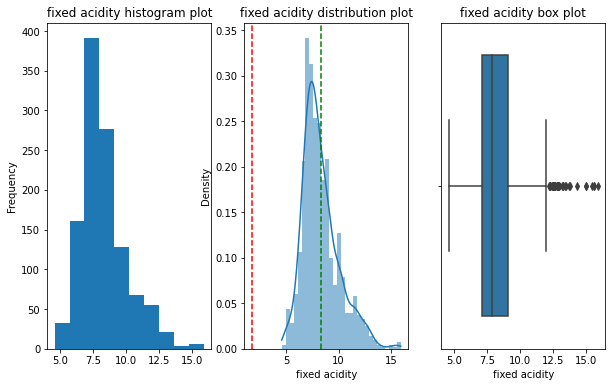

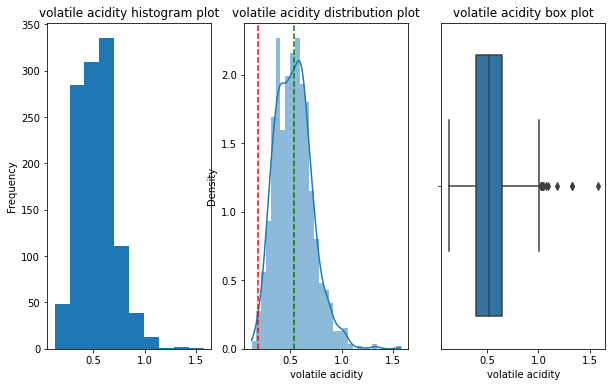

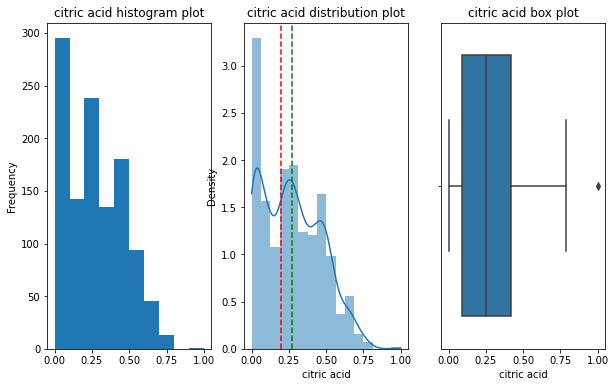

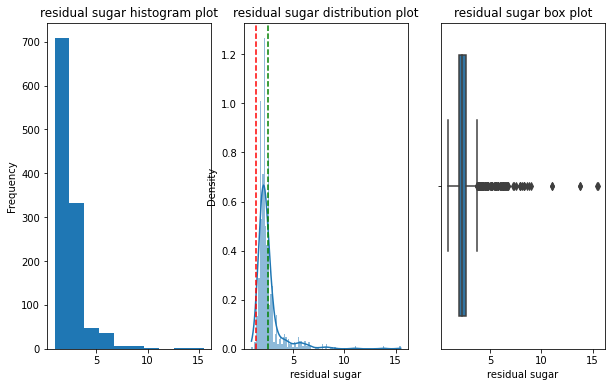

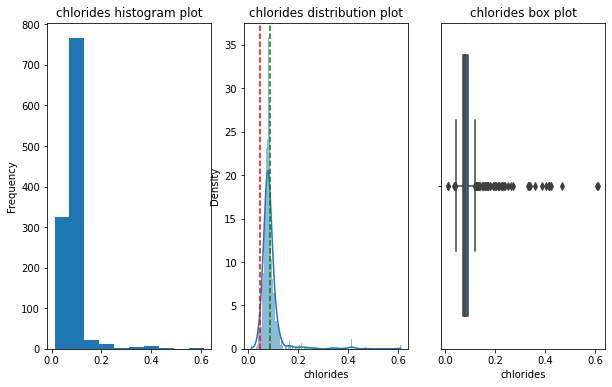

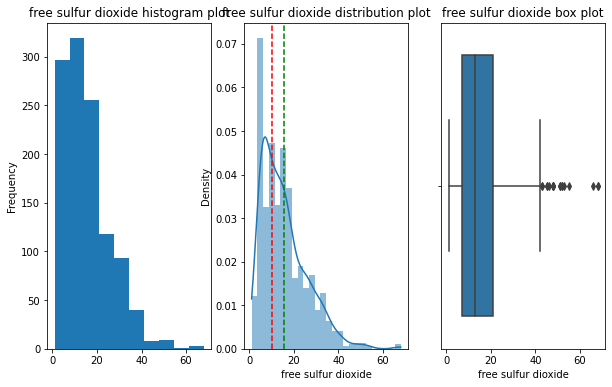

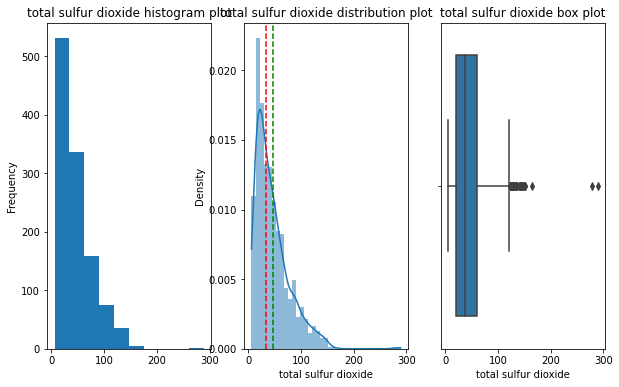

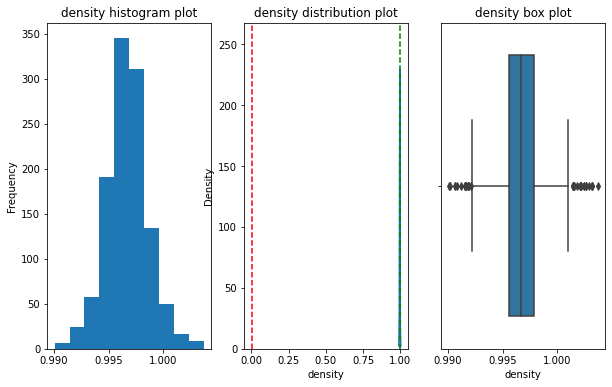

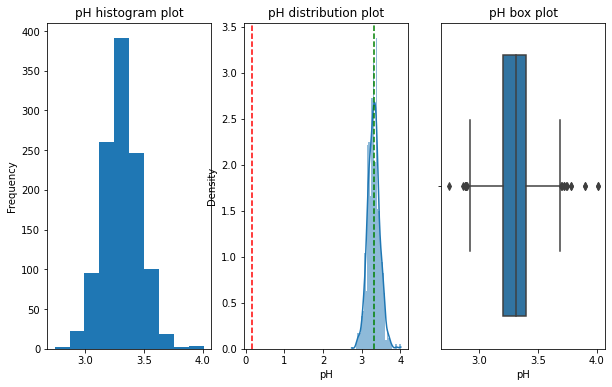

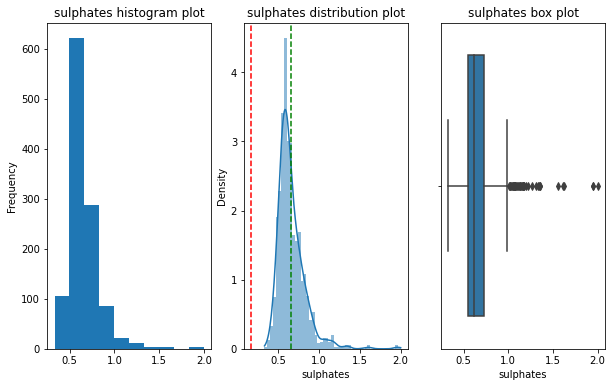

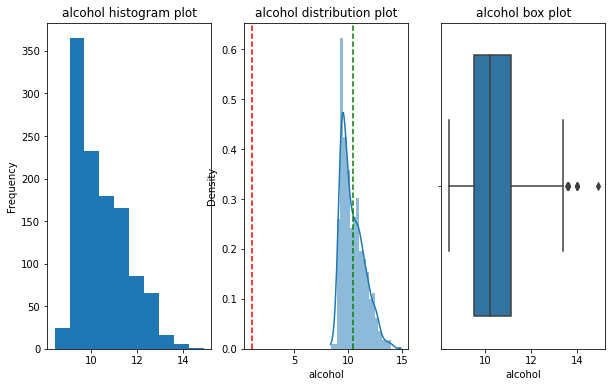

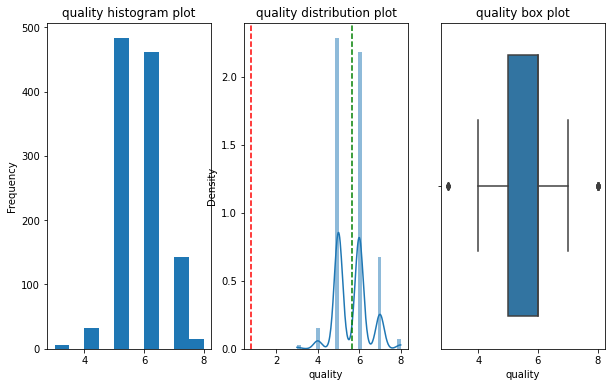

In [10]:
for feature in raw_data.columns:
    feat_plot(feature,raw_data)

<AxesSubplot:xlabel='fixed acidity', ylabel='density'>

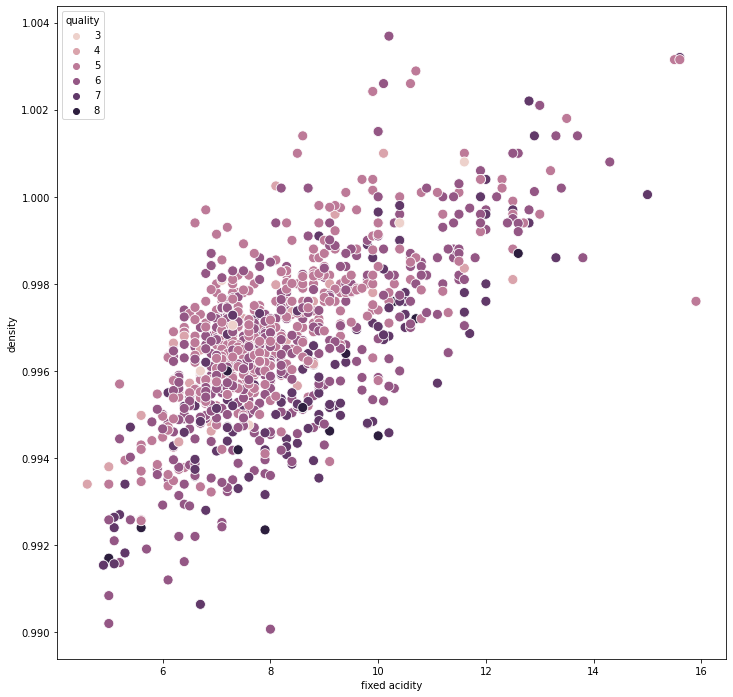

In [11]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=raw_data,x='fixed acidity',y='density',hue='quality',s=100)

<AxesSubplot:xlabel='fixed acidity', ylabel='citric acid'>

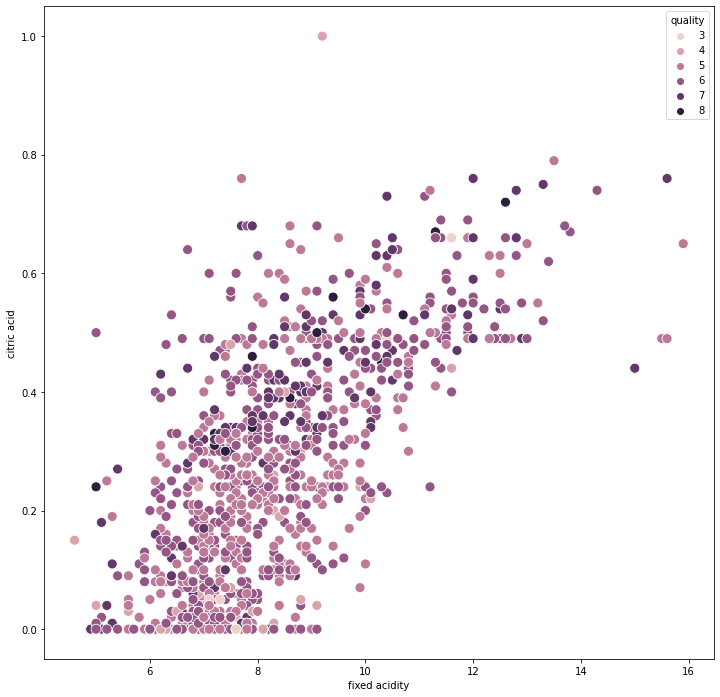

In [12]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=raw_data,x='fixed acidity',y='citric acid',hue='quality',s=100)

<AxesSubplot:xlabel='free sulfur dioxide', ylabel='total sulfur dioxide'>

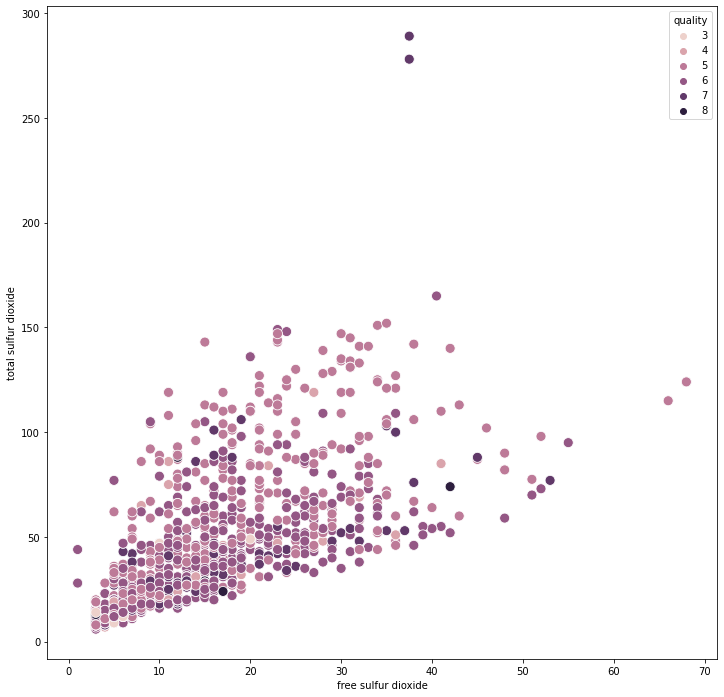

In [13]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=raw_data,x = 'free sulfur dioxide', y='total sulfur dioxide', hue = 'quality',s=100)

<AxesSubplot:xlabel='density', ylabel='alcohol'>

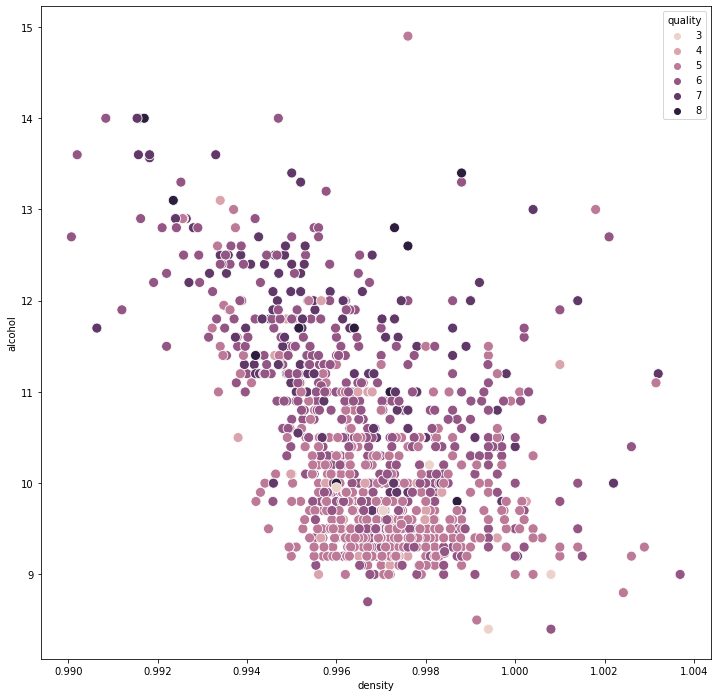

In [14]:
plt.figure(figsize=(12,12))
sns.scatterplot(data=raw_data,x = 'density', y='alcohol', hue = 'quality',s=100)

In [15]:
for column in raw_data.columns:
    print(f'{column}:{raw_data[column].value_counts().iloc[0]*100/raw_data.shape[0]} %')

fixed acidity:3.7620297462817147 %
volatile acidity:2.7996500437445317 %
citric acid:8.661417322834646 %
residual sugar:9.361329833770778 %
chlorides:4.199475065616798 %
free sulfur dioxide:8.661417322834646 %
total sulfur dioxide:3.1496062992125986 %
density:2.3622047244094486 %
pH:3.5870516185476817 %
sulphates:4.636920384951881 %
alcohol:8.048993875765529 %
quality:42.25721784776903 %


In [16]:
for column in raw_data.columns:
    Q3=raw_data[column].quantile(0.75)
    Q1=raw_data[column].quantile(0.25)
    IQR = Q3-Q1
    part_of_loses=raw_data[column][(raw_data[column]>Q1+1.5*IQR) | (raw_data[column]<Q1-1.5*IQR)].count()*100/raw_data.shape[0]
    print(f'Emissions for {column}:{part_of_loses} %')


Emissions for fixed acidity:14.260717410323709 %
Emissions for volatile acidity:9.186351706036746 %
Emissions for citric acid:6.47419072615923 %
Emissions for residual sugar:15.31058617672791 %
Emissions for chlorides:15.31058617672791 %
Emissions for free sulfur dioxide:12.160979877515311 %
Emissions for total sulfur dioxide:14.435695538057743 %
Emissions for density:13.123359580052494 %
Emissions for pH:12.598425196850394 %
Emissions for sulphates:11.986001749781277 %
Emissions for alcohol:11.986001749781277 %
Emissions for quality:14.435695538057743 %


In [17]:
indexes=[]
indexes_1=[]
emissions=[]
#drop_method
for column in raw_data.columns:
    if column!='quality':
        Q3=raw_data[column].quantile(0.75)
        Q1=raw_data[column].quantile(0.25)
        IQR = Q3-Q1
        indexes.append(raw_data[column][(raw_data[column]>Q1+1.5*IQR) | (raw_data[column]<Q1-1.5*IQR)].index.to_list())
for i in range(0,len(indexes)):
    indexes_1+=indexes[i]
indexes_for_dropping=pd.Series(indexes_1).value_counts().loc[pd.Series(indexes_1).value_counts()>5].index
data_drop_method=raw_data.drop(labels=indexes_for_dropping,axis=0)
y_drop_method=data_drop_method['quality']
X_drop_method=data_drop_method.drop(['quality'],axis=1)
X_drop_method_train,X_drop_method_test,y_drop_method_train,y_drop_method_test=train_test_split(X_drop_method,y_drop_method,train_size=0.8, test_size=0.2,random_state=0)
#without_drop
y=raw_data['quality']
X=raw_data.drop(['quality'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=0)
#with_transform
data_with_transform=raw_data.copy()
for column in data_with_transform.columns:
    if column!='quality':
        for i in range(0,data_with_transform.shape[0]):
            if i in indexes_for_dropping:
                data_with_transform.loc[i,column]=None
y_trans_method=data_with_transform['quality']
X_trans_method=data_with_transform.drop(['quality'],axis=1)   
X_trans_train,X_trans_test,y_trans_train,y_trans_test=train_test_split(X_trans_method,y_trans_method,train_size=0.8, test_size=0.2,random_state=0)




In [18]:
std=StandardScaler()
imputer=SimpleImputer(strategy='mean')
models=[SGDRegressor(),XGBRegressor(),Lasso(),Ridge(),SVR(),RandomForestRegressor()]
for model in models:
    # for_simple_data
    pipeline_for_simple_data=Pipeline(steps=[('std',std),('model',model)])
    mean_score_1=-1*cross_val_score(pipeline_for_simple_data,X_train,y_train,cv=5,scoring='neg_mean_absolute_error').mean()
    print(f'{model}: \n simple data: \n MAE - {mean_score_1}')
    # for_data_with_dropings
    pipeline_for_data_with_droppings=Pipeline(steps=[('std',std),('model',model)])
    mean_score_2=-1*cross_val_score(pipeline_for_data_with_droppings,X_drop_method_train,y_drop_method_train,cv=5,scoring='neg_mean_absolute_error').mean()
    print(f'{model}: \n data with droppings: \n MAE - {mean_score_2}')
    # for_transformed_data
    pipeline_for_transformed_data=Pipeline(steps=[('imputer',imputer),('std',std),('model',model)])
    mean_score_3=-1*cross_val_score(pipeline_for_transformed_data,X_trans_train,y_trans_train,cv=5,scoring='neg_mean_absolute_error').mean()
    print(f'{model}: \n transformed data: \n MAE - {mean_score_3}')

SGDRegressor(): 
 simple data: 
 MAE - 0.5075499688992691
SGDRegressor(): 
 data with droppings: 
 MAE - 0.48993189945368176
SGDRegressor(): 
 transformed data: 
 MAE - 0.5126170566875086
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None): 
 simple data: 
 MAE - 0.45024050722206377
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_b

In [19]:
RF_model=RandomForestRegressor(random_state=42)
param_grid = { 
    'RF__max_leaf_nodes': [100+i*10 for i in range(0,10)]}
pipeline_for_RandomForest=Pipeline(steps=[('std',std),('RF',RF_model)])
CV_1=GridSearchCV(pipeline_for_RandomForest,param_grid,n_jobs=4,cv=5,scoring='neg_mean_absolute_error')
CV_1.fit(X_drop_method_train,y_drop_method_train)
RF_end_model=RandomForestRegressor(max_leaf_nodes=CV_1.best_params_['RF__max_leaf_nodes'],random_state=42)
end_pipeline_RF=Pipeline(steps=[('std',std),('RF_end',RF_end_model)])
end_pipeline_RF.fit(X_drop_method_train,y_drop_method_train)
print(f'RF_MAE-{mean_absolute_error(end_pipeline_RF.predict(X_test),y_test)}')

RF_MAE-0.25671870087295073


In [20]:
SVR_model=SVR()
param_grid_1 = {
'SVR__epsilon': [0.0001-i*0.00001 for i in range(0,10)]}
pipeline_for_SVR=Pipeline(steps=[('std',std),('SVR',SVR_model)])
CV_2=GridSearchCV(pipeline_for_SVR,param_grid_1,n_jobs=4,cv=5,scoring='neg_mean_absolute_error')
CV_2.fit(X_drop_method_train,y_drop_method_train)
SVR_end_model=SVR(epsilon=CV_2.best_params_['SVR__epsilon'])
end_pipeline_SVR=Pipeline(steps=[('std',std),('SVR_end',SVR_end_model)])
end_pipeline_SVR.fit(X_drop_method_train,y_drop_method_train)
print(f'SVR_MAE-{mean_absolute_error(end_pipeline_SVR.predict(X_test),y_test)}')

    

SVR_MAE-0.3519343254936652


In [21]:
XGB_model=XGBRegressor(random_state=0)
param_grid_2 = {
'XGB__n_estimators': [100+25*i for i in range(0,10)]}
pipeline_for_XGBoost=Pipeline(steps=[('std',std),('XGB',XGB_model)])
CV_3=GridSearchCV(pipeline_for_XGBoost,param_grid_2,n_jobs=1,cv=5,scoring='neg_mean_absolute_error')
CV_3.fit(X_drop_method_train,y_drop_method_train)
XGB_end_model=XGBRegressor(epsilon=CV_3.best_params_['XGB__n_estimators'],random_state=0)
end_pipeline_XGB=Pipeline(steps=[('std',std),('XGB_end',XGB_end_model)])
end_pipeline_XGB.fit(X_drop_method_train,y_drop_method_train)
print(f'XGB_MAE-{mean_absolute_error(end_pipeline_XGB.predict(X_test),y_test)}')


[16:37:33] WARNING: ../src/learner.cc:576: 
Parameters: { "epsilon" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGB_MAE-0.15909918531059697
